# Part I - Accident and Emergency Department Synthetic Admission Data Analysis
## by Generoso Roberto

## Introduction

Analysis of health care data has a huge potential to improve health services and patient outcomes but practicing and creating analytical tools and processes is tricky since patient privacy needs to be preserved. The dataset that is used is the A&E Synthetic Data which created as a result of an NHS England pilot project to share more data without sacrifising the privacy of patients. The project used statistical models to that tries create datasets that retains the value of the original data but can not be used to re-identify specific individual records. 

This provides an opportunity for us to get to look and analyze the A&E data that NHS collects. For this analysis the focus is on admitted cases in just one hospital.

The columns in the dataset are the following:
* `IMD_Decile_From_LSOA` - measure of deprivation. A score of 1 indicates the entry comes from the 10% most deprived area in England
* `Age_Band` - The interval of the age of the patient
* `Sex` - Coded in 1 and 2 to represent the two sexes
* `AE_Arrive_Date` - The date the patient arrived at the A&E provider
* `AE_Arrive_HourOfDay` - The interval of what time the patient arrived at the A&E
* `AE_Time_Mins` - Total number of minutes the patient stayed in the A&E
* `AE_HRG` - Code for the health reference group
* `AE_Num_Diagnoses` - Number of diagnoses the patient have in the A&E
* `AE_Num_Investigations` - Number of investigations done to the patient
* `AE_Num_Treatments` - Number of treatments done to the patient
* `AE_Arrival_Mode` - Code for the mode by which  patient arrived
* `Provider_Patient_Distance_Miles` - Distance from the patient place of origin to the provider in miles
* `Admission_Method` - Code for the method how the patient was admitted
* `ICD10_Chapter_Code` - International classification of disease chapter code
* `Treatment_Function_Code` - The treatment function under which the patient is treated.
* `Length_Of_Stay_Days` - The number of days the patient was admitted

## Preliminary Data Wrangling

In [238]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [239]:
#Load the dataset
aedata_df_original=pd.read_csv('AnE_Synthetic_Data_Provider_Admission.csv')
aedata_df = aedata_df_original

In [240]:
# High-level overview of data shape and composition
print(aedata_df.shape)
print(aedata_df.info())
print(aedata_df.head(10))
columns = aedata_df.columns
for column in columns:
    print(f'{column}: {aedata_df[column].unique()}')

(326444, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326444 entries, 0 to 326443
Data columns (total 16 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   IMD_Decile_From_LSOA             326444 non-null  int64  
 1   Age_Band                         326444 non-null  object 
 2   Sex                              326444 non-null  int64  
 3   AE_Arrive_Date                   326444 non-null  object 
 4   AE_Arrive_HourOfDay              326444 non-null  object 
 5   AE_Time_Mins                     326444 non-null  float64
 6   AE_HRG                           326372 non-null  object 
 7   AE_Num_Diagnoses                 326444 non-null  int64  
 8   AE_Num_Investigations            326444 non-null  int64  
 9   AE_Num_Treatments                326444 non-null  int64  
 10  AE_Arrival_Mode                  326444 non-null  int64  
 11  Provider_Patient_Distance_Miles  326444 non-null  fl

1. `AE_Arrive_Date` is an object and should be made into a datetime and extract the year, month and weekday
2. The following columns are categorical types
    * `Sex`
    * `AE_Arrival_Mode`
    * `Admission_Method`
    * `ICD10_Chapter_Code`
    * `Treatment_Function_Code`
    * `AE_Arrive_HourOfDay`
2. The following columns are ordered categorical types
    * `IMD_Decile_From_LSOA`
    * `Age_Band`
    * `AE_Arrive_HourOfDay`
    * `AE_HRG`
3. The following columns have null values:
    * `AE_HRG`
    * `ICD10_Chapter_Code`
    * `Treatment_Function_Code`
    * `Length_Of_Stay_Days`

In [241]:
# 1. Convert 'AE_Arrive_Date' to datetime
aedata_df['AE_Arrive_Date']=pd.to_datetime(aedata_df['AE_Arrive_Date'])
# Check the dtype of 'AE_Arrive_Date'
print(f"The datatype of the column AE_Arrive_Date is {aedata_df['AE_Arrive_Date'].dtype}")
# Extract year, month and weekday
aedata_df['Year'] = aedata_df['AE_Arrive_Date'].dt.strftime('%Y')
aedata_df['Month'] = aedata_df['AE_Arrive_Date'].dt.strftime('%b')
aedata_df['Weekday'] = aedata_df['AE_Arrive_Date'].dt.strftime('%a')
# Check the Year_Month column
aedata_df[['Year','Month','Weekday']]

The datatype of the column AE_Arrive_Date is datetime64[ns]


,Year,Month,Weekday
0,2015,May,Thu
1,2017,Sep,Sat
2,2016,Sep,Wed
3,2014,Mar,Sun
4,2017,Nov,Sat
...,...,...,...
326439,2017,Nov,Thu
326440,2017,May,Fri
326441,2015,Jul,Sun
326442,2016,Aug,Fri


In [242]:
# 2. Convert columns into categorical type
# Create a function that converts columns into category
def covert_to_categorical(df, column_list):
    for column in column_list:
        df[column] = df[column].astype('category')
# Create a list of columns to be made into category
categorical_columns = [\
    'Sex',
    'AE_Arrival_Mode',
    'Admission_Method',
    'ICD10_Chapter_Code',
    'Treatment_Function_Code',
    'AE_Arrive_HourOfDay',
    'Year',
    'Month',
    'Weekday'
    ]
# Convert columns into category
covert_to_categorical(aedata_df,categorical_columns)
# Check the dtypes
aedata_df[categorical_columns].dtypes

Sex                        category
AE_Arrival_Mode            category
Admission_Method           category
ICD10_Chapter_Code         category
Treatment_Function_Code    category
AE_Arrive_HourOfDay        category
Year                       category
Month                      category
Weekday                    category
dtype: object

In [243]:
# 3. Convert column to categorical types
# Create a list of columns to be made into ordered categorical data
ordinal_columns = [\
    'IMD_Decile_From_LSOA',
    'Age_Band',
    'AE_Arrive_HourOfDay',
    'AE_HRG',
    'Year',
    'Month',
    'Weekday'
    ]
# Check the different values of the columns to be changed into ordered category
# Create a function to print the unique values
def check_unique_values(df, column_list):
    for column in column_list:
        print(f'{column} : {df[column].unique()}')
# Check the unique values of the identified ordered categorical types
check_unique_values(aedata_df, ordinal_columns)

IMD_Decile_From_LSOA : [ 2  3  1  4  8  9  5  7  6 10]
Age_Band : ['1-17' '65-84' '85+' '18-24' '45-64' '25-44']
AE_Arrive_HourOfDay : ['17-20', '13-16', '05-08', '21-24', '09-12', '01-04']
Categories (6, object): ['01-04', '05-08', '09-12', '13-16', '17-20', '21-24']
AE_HRG : ['Nothing' 'Low' 'High' 'Medium' nan]
Year : ['2015', '2017', '2016', '2014', '2018']
Categories (5, object): ['2014', '2015', '2016', '2017', '2018']
Month : ['May', 'Sep', 'Mar', 'Nov', 'Jan', ..., 'Jun', 'Aug', 'Oct', 'Apr', 'Dec']
Length: 12
Categories (12, object): ['Apr', 'Aug', 'Dec', 'Feb', ..., 'May', 'Nov', 'Oct', 'Sep']
Weekday : ['Thu', 'Sat', 'Wed', 'Sun', 'Fri', 'Mon', 'Tue']
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']


In [244]:
# Convert the ordered_categorical_columns into category type
covert_to_categorical(aedata_df,ordinal_columns)
# Create a dictionary that shows the order of the values
ordinal_columns_dict={\
    'IMD_Decile_From_LSOA': [1,2,3,4,5,6,7,8,9,10],
    'Age_Band':['1-17','18-24','25-44', '45-64', '65-84', '85+'],
    'AE_HRG':['Nothing','Low','Medium','High'],
    'Year':['2014', '2015', '2016', '2017', '2018'],
    'Month':['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug',
    'Sep','Oct','Nov','Dec'],
    'Weekday':['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],
    'AE_Arrive_HourOfDay':['01-04','05-08','09-12','13-16','17-20','21-24']
    }
# Create a function that uses a dictionary to order the ordinal columns
def order_categorical(df, column_dict):
    for column in column_dict:
        df[column] = df[column].cat.set_categories(column_dict[column], ordered=True)
# Order the ordinal categorical data
order_categorical(aedata_df,ordinal_columns_dict)

In [245]:
# Check the ordinal columns
for column in ordinal_columns:
    print(aedata_df[column])

0         2
1         2
2         3
3         1
4         2
         ..
326439    1
326440    3
326441    3
326442    2
326443    2
Name: IMD_Decile_From_LSOA, Length: 326444, dtype: category
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]
0          1-17
1         65-84
2          1-17
3           85+
4          1-17
          ...  
326439     1-17
326440    65-84
326441    25-44
326442    45-64
326443    65-84
Name: Age_Band, Length: 326444, dtype: category
Categories (6, object): ['1-17' < '18-24' < '25-44' < '45-64' < '65-84' < '85+']
0         17-20
1         13-16
2         17-20
3         05-08
4         13-16
          ...  
326439    21-24
326440    21-24
326441    01-04
326442    17-20
326443    13-16
Name: AE_Arrive_HourOfDay, Length: 326444, dtype: category
Categories (6, object): ['01-04' < '05-08' < '09-12' < '13-16' < '17-20' < '21-24']
0         Nothing
1             Low
2             Low
3             Low
4             Low
           ...   
326439     Medium

Since there are several variables that are coded, for ease of analysis I decoded them.

In [246]:
# Decode the sex column
def decode(data, column, reference):
    data = data.merge(pd.read_csv(reference),how='left',on=column)
    return data['Description']
aedata_df['Sex'] = decode(aedata_df,'Sex','Sex_Code.csv')

In [247]:
# Decode the Admission_Method column
aedata_df['Admission_Method']=decode(aedata_df,'Admission_Method','Admission_Method.csv')

In [248]:
# Decode the ICD10_Chapter_Code column
aedata_df['ICD10_Chapter_Code']=decode(aedata_df,'ICD10_Chapter_Code','ICD10chapters.csv')

In [249]:
# Decode the Treatment_Function_Code column
aedata_df['Treatment_Function_Code']=decode(aedata_df,'Treatment_Function_Code','Treatment_Function_Code.csv')

In [250]:
# Decode the AE_Arrival_Mode
aedata_df['AE_Arrival_Mode']=aedata_df['AE_Arrival_Mode'].apply(lambda x: 'Private Transpo' if x==2 else('Ambulance' if x==1 else 'Others') )

In [251]:
# 4. Check the rows that have null values
print(aedata_df[aedata_df.isna().any(axis=1)])

       IMD_Decile_From_LSOA Age_Band     Sex AE_Arrive_Date  \
42                        5    65-84    Male     2017-01-05   
90                        3    65-84  Female     2018-01-09   
190                       1     1-17    Male     2017-03-28   
231                       2     1-17  Female     2016-07-05   
289                       1     1-17    Male     2015-08-26   
...                     ...      ...     ...            ...   
326188                    2    25-44  Female     2016-01-30   
326324                    6    65-84  Female     2016-09-03   
326343                    5    45-64  Female     2018-03-18   
326358                    4    25-44    Male     2015-04-12   
326364                    2    65-84  Female     2016-03-24   

       AE_Arrive_HourOfDay  AE_Time_Mins   AE_HRG  AE_Num_Diagnoses  \
42                   05-08         320.0     High                 0   
90                   13-16         160.0   Medium                 0   
190                  05-08    

What percentage of the rows in the dataset have missing values?

In [252]:
# Compute the percentage of rows that have missing values
print(f"{round(len(aedata_df[aedata_df.isna().any(axis=1)])/len(aedata_df)*100,2)} % of rows have a null value.")

1.44 % of rows have a null value.


Theoretically, these null values would need to be farther assessed. Weather the null values are missing in a systematic way or purely random, weather the missing values could be imputed etc. But in the interest of time, I decided to remove the rows that have null values.

In [253]:
# Remove rows that have null values
aedata_df.dropna(axis=0,inplace=True)
# Check again the info of the working dataframe
aedata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321748 entries, 0 to 326443
Data columns (total 19 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   IMD_Decile_From_LSOA             321748 non-null  category      
 1   Age_Band                         321748 non-null  category      
 2   Sex                              321748 non-null  object        
 3   AE_Arrive_Date                   321748 non-null  datetime64[ns]
 4   AE_Arrive_HourOfDay              321748 non-null  category      
 5   AE_Time_Mins                     321748 non-null  float64       
 6   AE_HRG                           321748 non-null  category      
 7   AE_Num_Diagnoses                 321748 non-null  int64         
 8   AE_Num_Investigations            321748 non-null  int64         
 9   AE_Num_Treatments                321748 non-null  int64         
 10  AE_Arrival_Mode                  321748 non-

In [254]:
# descriptive statistics for numeric variables
print(aedata_df.describe().T)

                                    count        mean         std  min    25%  \
AE_Time_Mins                     321748.0  286.239510  172.121087  0.0  200.0   
AE_Num_Diagnoses                 321748.0    0.341323    0.696037  0.0    0.0   
AE_Num_Investigations            321748.0    6.778420    3.480049  0.0    4.0   
AE_Num_Treatments                321748.0    3.599043    2.351271  0.0    2.0   
Provider_Patient_Distance_Miles  321748.0    4.751557   13.997934  0.0    1.0   
Length_Of_Stay_Days              321748.0    4.329659    9.588165  0.0    0.0   

                                   50%    75%     max  
AE_Time_Mins                     240.0  340.0  1440.0  
AE_Num_Diagnoses                   0.0    1.0    10.0  
AE_Num_Investigations              8.0   10.0    10.0  
AE_Num_Treatments                  3.0    5.0    10.0  
Provider_Patient_Distance_Miles    2.0    4.0   200.0  
Length_Of_Stay_Days                1.0    4.0   180.0  


In [255]:
# descriptive statistics for categorical variables
print(aedata_df[[\
    'IMD_Decile_From_LSOA',
    'Age_Band',
    'Sex',
    'AE_Arrive_HourOfDay',
    'AE_HRG',
    'AE_Arrival_Mode',
    'Admission_Method',
    'ICD10_Chapter_Code',
    'Treatment_Function_Code',
    'Year',
    'Month',
    'Weekday'
    ]].describe().T)

                          count unique                                  top  \
IMD_Decile_From_LSOA     321748     10                                    2   
Age_Band                 321748      6                                65-84   
Sex                      321748      2                               Female   
AE_Arrive_HourOfDay      321748      6                                13-16   
AE_HRG                   321748      4                                  Low   
AE_Arrival_Mode          321748      3                      Private Transpo   
Admission_Method         321748      9  Emergency: Provider's ED or dent      
ICD10_Chapter_Code       321748      6                                Other   
Treatment_Function_Code  321748      5           Emergency Medicine Service   
Year                     321748      5                                 2016   
Month                    321748     12                                  Mar   
Weekday                  321748      7              

In [256]:
aedata_df.to_csv('dataset_for_analysis.csv')

### What is the structure of your dataset?

> There are 321,749 A&E patient consult in the working dataset with 17 features. Four are date or period data, 6 are numeric variables, 5 categorical variables and 3 ordinal variables.
> For the ordinal variables the following are values arranged smallest to largest:
> * `IMD_Decile_From_LSOA`: 1,2,3,4,5,6,7,8,9,10
> * 'Age_Band':['1-17','18-24','25-44', '45-64', '65-84', '85+']
> * `AE_HRG`: Nothing, Low, Medium, High

### What is/are the main feature(s) of interest in your dataset?

> I want to figure out what are the features that could help in predicting the amount of time spent in the A&E (`AE_Time_Mins`) 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
> I could categorize the features of the dataset into the following:
> 1. A&E activities:
> * `AE_Num_Diagnoses`
> * `AE_Num_Investigations`
> * `AE_Num_Treatments`
> 2. Sociodemographic factors:
> * `IMD_Decile_From_LSOA`
> * `Age_Band`
> * `Sex`
> * `Provider_Patient_Distance_Miles`
> 3. Temporal factors:
> * `Year`
> * `Month`
> * `Weekday`
> * `AE_Arrive_HourOfDay`
> 4. Transfer Method:
> * `AE_Arrival_Mode`
> * `Admission_Method`
> 5. Disease and Treatment Factors
> * `AE_HRG`
> * `ICD10_Chapter_Code`
> * `Treatment_Function_Code`
> * `Length_Of_Stay_Days`

> For the amount of time spent in the A&E, I expect that A&E activities and temporal factors could contribute the most but other variables could also contribute.

## Visualization Functions
This section will show all the functions that I created for this analysis.

In [257]:
aedata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321748 entries, 0 to 326443
Data columns (total 19 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   IMD_Decile_From_LSOA             321748 non-null  category      
 1   Age_Band                         321748 non-null  category      
 2   Sex                              321748 non-null  object        
 3   AE_Arrive_Date                   321748 non-null  datetime64[ns]
 4   AE_Arrive_HourOfDay              321748 non-null  category      
 5   AE_Time_Mins                     321748 non-null  float64       
 6   AE_HRG                           321748 non-null  category      
 7   AE_Num_Diagnoses                 321748 non-null  int64         
 8   AE_Num_Investigations            321748 non-null  int64         
 9   AE_Num_Treatments                321748 non-null  int64         
 10  AE_Arrival_Mode                  321748 non-

In [258]:
def rename_variable(x):
    new_name = {'IMD_Decile_From_LSOA':'Measure of Deprivation (decile)',
    'Age_Band':'Age',
    'Sex':'Sex',
    'AE_Arrive_HourOfDay':'Hour of Arrival in A&E',
    'AE_Time_Mins': 'Time Spent in the A&E(min)',
    'AE_HRG':'Healthcare Resource Grouping',
    'AE_Num_Diagnoses': 'Number of Diagnoses at the A&E',
    'AE_Num_Investigations': 'Number of Investigations at the A&E',
    'AE_Num_Treatments': 'Number of Treatments at the A&E',
    'AE_Arrival_Mode':'Mode of Transpo to A&E',
    'Provider_Patient_Distance_Miles': 'Provider to Patient Distance (miles)',
    'Admission_Method': 'Admission Method',
    'ICD10_Chapter_Code':'ICD10 Chapter',
    'Treatment_Function_Code': 'Treatment Function',
    'Length_Of_Stay_Days': 'Time Spent Admitted(days)',
    'Year':'Year',
    'Month':'Month',
    'Weekday':'Day of the Week',
    'median':'Median Daily Number of Admissions',
    'log_ae_time':'Log of Time Spent in the A&E (min)',
    'log_admission': 'Log of Time Spent Admitted (days)',
    'log_distance': 'Log of Provider-Patient distance(miles)'
    }
    return new_name[x]

In [259]:
# function that checks if a variable is ordinal
def check_order(x):
    order=['IMD_Decile_From_LSOA','Age_Band','AE_HRG', 'AE_Arrive_HourOfDay',
    'Year', 'Month','Weekday']
    return x not in order

In [310]:
# Create a function to create a count plot
def create_countplot(data, x, title, counter=0, order=True):
    # if for only one graph
    if counter==0:
        plt.figure(figsize=(16,8))
        # if statement for order or not
        if order==True:
            ax=sns.countplot(data=data, x=x, order=data[x].value_counts().index, color='lightblue')
        else:
            ax=sns.countplot(data=data, x=x, color='lightblue')
        # annotate the percentage
        for c in ax.containers:
            # calculate percentage for labels
            labels=[f'{h/data[x].count()*100:0.1f}%' if (h:=v.get_height())>0 else '' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge')
        for tick in ax.get_xticklabels():
            tick.set_rotation(75)
        ax.set(xlabel=title)
        ax.set(title=f'Distribution by {title}')
    else:
        # if statement for order or not
        if order==True:
            sns.countplot(data=data, x=x, order=data[x].value_counts().index, color='lightblue',ax=counter)
        else:
            sns.countplot(data=data, x=x, color='lightblue', ax=counter)
        # annotate the percentage
        for c in counter.containers:
            # calculate percentage for labels
            labels=[f'{h/data[x].count()*100:0.1f}%' if (h:=v.get_height())>0 else '' for v in c]
            counter.bar_label(c, labels=labels, label_type='edge')
        for tick in counter.get_xticklabels():
            tick.set_rotation(75)
        counter.set(xlabel=title)
        counter.set(title=f'Distribution by {title}')


In [261]:
# Create a function that creates histograms
def create_histogram(data, x, title, counter=0):
    # if for only one graph
    if counter==0:
        plt.figure(figsize=(16,8))
        sns.histplot(data=data, x=x, color='lightblue', binwidth=1)
        plt.xlabel(title)
        plt.title(f'Histogram of the {title}')
    else:
        sns.histplot(data=data, x=x, ax=counter, color='lightblue', bins=11)
        counter.set(xlabel=title)
        counter.set(title=f'Histogram of {title}')

In [262]:
# Create a function that graphs multiple variables at once
def univariate_multiplot(data,list_of_x=[], order=True):
    counter=0
    fig,ax=plt.subplots(nrows=len(list_of_x), figsize=[16,8*len(list_of_x)])
    for x in list_of_x:
        title = rename_variable(x)
        order = check_order(x)
        if data[x].dtype=='category':
            create_countplot(data,x,title,ax[counter],order)
        else:
            create_histogram(data,x,title,ax[counter])
        counter+=1
        

In [263]:
# Create a function that outputs the order of ordinal columns
def get_order(column):
    ordinal_columns_dict={\
        'IMD_Decile_From_LSOA': [1,2,3,4,5,6,7,8,9,10],
        'Age_Band':['1-17','18-24','25-44', '45-64', '65-84', '85+'],
        'AE_HRG':['Nothing','Low','Medium','High'],
        'Year':['2014', '2015', '2016', '2017', '2018'],
        'Month':['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug',
        'Sep','Oct','Nov','Dec'],
        'Weekday':['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],
        'AE_Arrive_HourOfDay':['01-04','05-08','09-12','13-16','17-20','21-24']
        }
    return ordinal_columns_dict[column]

In [264]:
#Create a function that create barplot for median daily admission
def create_barplot_mda(data, x, y):
    x_rename = rename_variable(x)
    y_rename = rename_variable(y)
    plt.figure(figsize=(16,8))
    sns.barplot(data=data,x=x,y=y,color='lightblue',order=get_order(x))
    plt.xlabel(x_rename)
    plt.ylabel(y_rename)
    plt.title(f'Barplot of the {y_rename} by {x_rename}')

In [265]:
#Create a scatterplot between two variables
def create_scatterplot(data, x, y):
    x_rename = rename_variable(x)
    y_rename = rename_variable(y)
    plt.figure(figsize=(16,8))
    sns.scatterplot(data=data, x=x, y=y, color='lightblue')
    plt.xlabel(x_rename)
    plt.ylabel(y_rename)
    plt.title(f'{x_rename} x {y_rename} (Correlation: {round(data[x].corr(data[y]),3)})')

In [266]:
#Create a correlation plot
def create_corrplot(data,list_of_columns,title):
    plt.figure(figsize=(16,8))
    sns.heatmap(data[list_of_columns].corr(), annot =True, fmt='.3f',
    cmap='vlag_r', center=0)
    plt.title(title)

In [267]:
#Create a pairgrid
def create_pairplot(data, list_of_columns, title):
    #since there are a lot of rows, we will sample 500 from the dataset
    data_samp=data.sample(n=500, replace=False)
    sns.pairplot(data_samp[list_of_columns])
    plt.title(title)

In [318]:
#Create a counplot with hue
def create_bvcountplot(data, x, y, order=True, palette='Blues' ):
    plt.figure(figsize=(9,4))
    if order==True:
        ax=sns.countplot(data=data, x=x, hue=y, order=data[x].value_counts().index, palette = palette)
    else:
        ax=sns.countplot(data=data, x=x, hue=y, palette = palette)
    # annotate the percentage
    ax.set(xlabel=rename_variable(x))
    for tick in ax.get_xticklabels():
        tick.set_rotation(75)
    ax.set(title=f'Distribution by {rename_variable(x)} and {rename_variable(y)}')

In [269]:
def create_bvboxplot(data, y, x, order=True):
    x_rename = rename_variable(x)
    y_rename = rename_variable(y)
    plt.figure(figsize=(9,4))
    if order==True:
        ax=sns.boxplot(data=data, x=x, y=y, order=data[x].value_counts().index, color='lightblue',showfliers=False)
    else:
        ax=sns.boxplot(data=data, x=x, y=y, color='lightblue',showfliers=False)
    # annotate the percentage
    ax.set(xlabel=rename_variable(x))
    for tick in ax.get_xticklabels():
        tick.set_rotation(75)
    plt.xlabel(x_rename)
    plt.ylabel(y_rename)
    plt.title(f'Boxplot by {x_rename} and {y_rename}')

In [329]:
def create_bvbarh(data, x, y, stacked=True, figsize=(9,4)):
    x_rename = rename_variable(x)
    y_rename = rename_variable(y)
    data.groupby(x)[y].value_counts(normalize=True).mul(100).unstack(level=-1).plot.barh(stacked=stacked, figsize=figsize)
    plt.ylabel(x_rename)
    plt.title(f'Percentage Bar Chart by {x_rename} and {y_rename}')

In [271]:
#Create a scatterplot between two variables
def create_mvscatterplot(data, x, y,z):
    x_rename = rename_variable(x)
    y_rename = rename_variable(y)
    z_rename = rename_variable(z)
    plt.figure(figsize=(16,8))
    sns.scatterplot(data=data, x=x, y=y, hue=z)
    plt.xlabel(x_rename)
    plt.ylabel(y_rename)
    plt.title(f'Scatterplot {x_rename} x {y_rename} grouped by {z_rename}')

In [272]:
def create_mvpointplot(data, x, y, z):
    x_rename = rename_variable(x)
    y_rename = rename_variable(y)
    z_rename = rename_variable(z)
    plt.figure(figsize=(16,8))
    ax=sns.pointplot(data=data, x=x, y=y, hue=z, palette='Blues', errorbar='ci', estimator=np.median, alpha=0.1)
    #ax.axhline(data['AE_Time_Mins'].median(), color='green', alpha=0.75)
    plt.xlabel(x_rename)
    plt.ylabel(y_rename)
    plt.title(f'{x_rename} x Median {y_rename} grouped by {z_rename})')    

In [273]:
def create_mvboxplot(data, x, y, z, order=True):
    x_rename = rename_variable(x)
    y_rename = rename_variable(y)
    z_rename = rename_variable(z)
    plt.figure(figsize=(16,8))
    if order==True:
        ax=sns.boxplot(data=data, x=x, y=y, hue=z, order=data[x].value_counts().index, palette='Blues', showfliers=False)
    else:
        ax=sns.boxplot(data=data, x=x, y=y, hue=z, palette='Blues', showfliers=False)
    # annotate the percentage
    ax.axvline(data['AE_Time_Mins'].median(), color='green', alpha=0.75)
    ax.set(xlabel=x_rename)
    ax.set(ylabel=y_rename)
    ax.set(title=f'{x_rename} x {y_rename} grouped by {z_rename})')

### Dependent Variable

What are the distribution of the main variables?

#### Amount of time at the A&E

Text(0.5, 1.0, 'Histogram of the Time Spent in the A&E(min)')

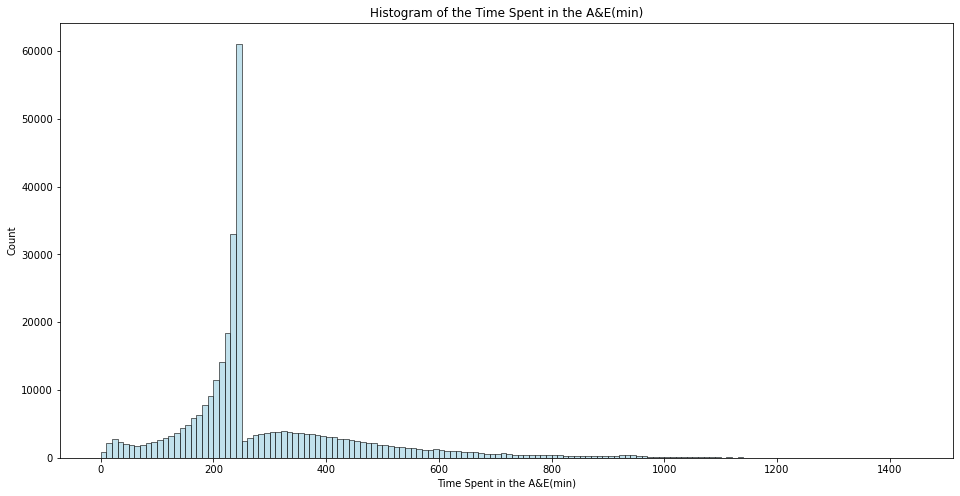

In [274]:
# plot the histogram of the amount of time at the A&E
x_var=rename_variable('AE_Time_Mins')
plt.figure(figsize=(16,8))
sns.histplot(data=aedata_df, x='AE_Time_Mins', color='lightblue', binwidth=10)
plt.xlabel(x_var)
plt.title(f'Histogram of the {x_var}')

The total time spent by admitted patient in the A&E initially initially peaked at around 20-30min then reach the highest point at around 240-250min then a small peak at around 300-320min.

Since there is a long tail in the distribution, what does the ditribution look like in log scale?

C:\Users\gener\AppData\Local\Temp\ipykernel_28012\1300726639.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aedata_df['log_ae_time']=aedata_df['AE_Time_Mins'].apply(lambda x: np.log10(x))


([<matplotlib.axis.XTick at 0x17faa39f4f0>,
 [Text(1.0, 0, '10'),
  Text(1.5, 0, '31.63'),
  Text(2.0, 0, '100'),
  Text(2.5, 0, '316.23'),
  Text(3.0, 0, '1k')])

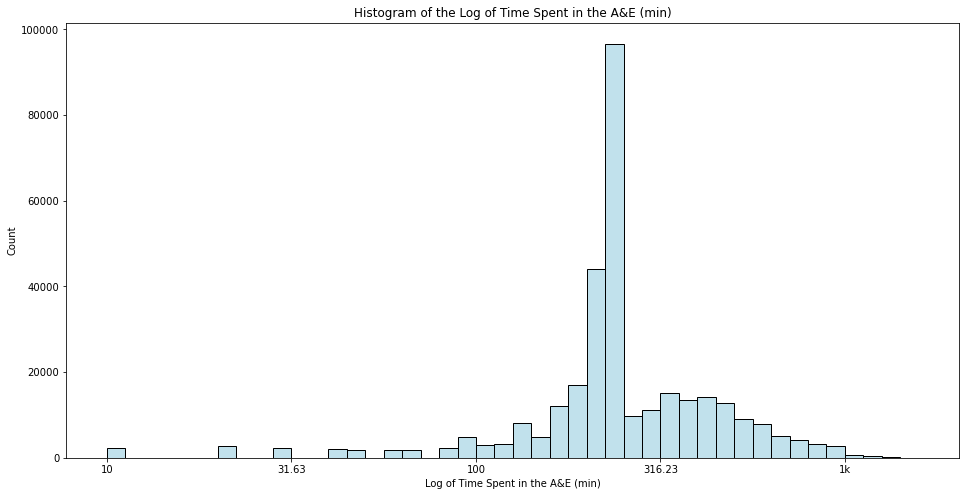

In [275]:
# Since log10(0) is infinite and since 0min spent in 
# and A&E would need more industry knowledge if such is applicable or not,
# I resolved that moving forward I would filter out rows that have 0 for their AE_Time_Mins
aedata_df=aedata_df[aedata_df['AE_Time_Mins']>0]
# Compute for the log value of the time in min
aedata_df['log_ae_time']=aedata_df['AE_Time_Mins'].apply(lambda x: np.log10(x))
# Plot the histogram of the log of the value
x_var=rename_variable('log_ae_time')
plt.figure(figsize=(16,8))
sns.histplot(data=aedata_df, x='log_ae_time', color='lightblue', binwidth=0.05)
plt.xlabel(x_var)
plt.title(f'Histogram of the {x_var}')
# Change the xticks to be more understandable
plt.xticks([1.0,1.5,2.0,2.5,3.0], [10, 31.63, 100, 316.23, '1k'])

In the graph we see that the number of minutes, there are two peaks. One is between 223.87 to 251.19 min followed by sharp decline then another peak albeight at a far lesser magnitude at 316.23-398.11min.

### Number of Days admitted

### A&E Activities

I look at the number of diagnoses, investigations and treatments at the A&E

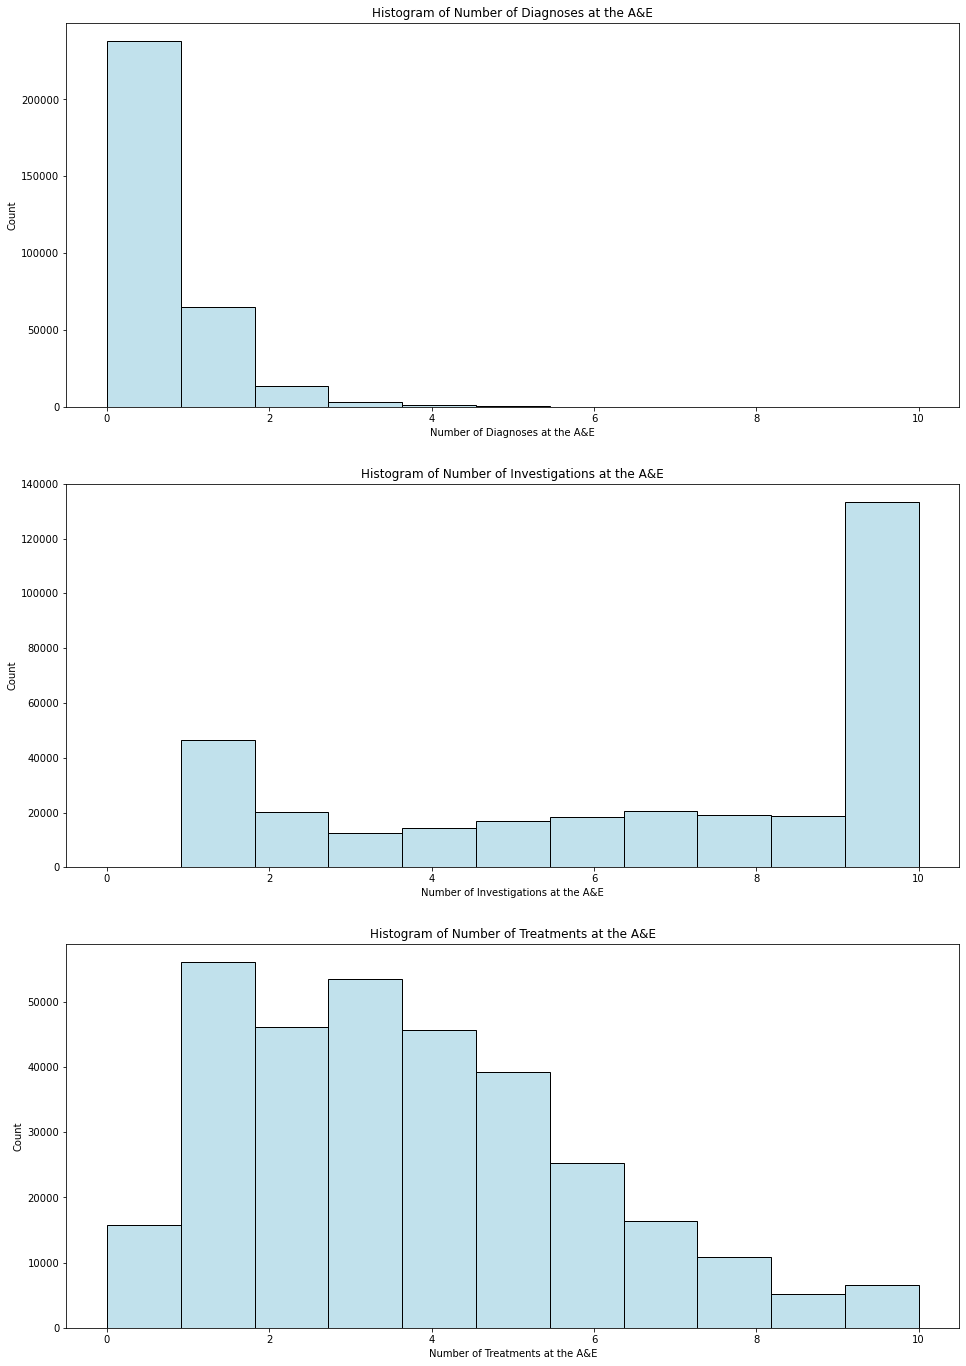

In [276]:
# Graph the three variables
univariate_multiplot(aedata_df,['AE_Num_Diagnoses','AE_Num_Investigations','AE_Num_Treatments'])

* The vast majority have zero diagnoses at the A&E
* Distribution of the number of investigations seems to be bimodal. The first peak is at one investigation done and the next and the mojority is at 10 investigations done
* The distribution looks more like a normal ditribution but the highest counts is seen at 1 and 3 treatments done.

### Sociodemographic factors

Text(0.5, 1.0, 'Histogram of the Provider to Patient Distance (miles)')

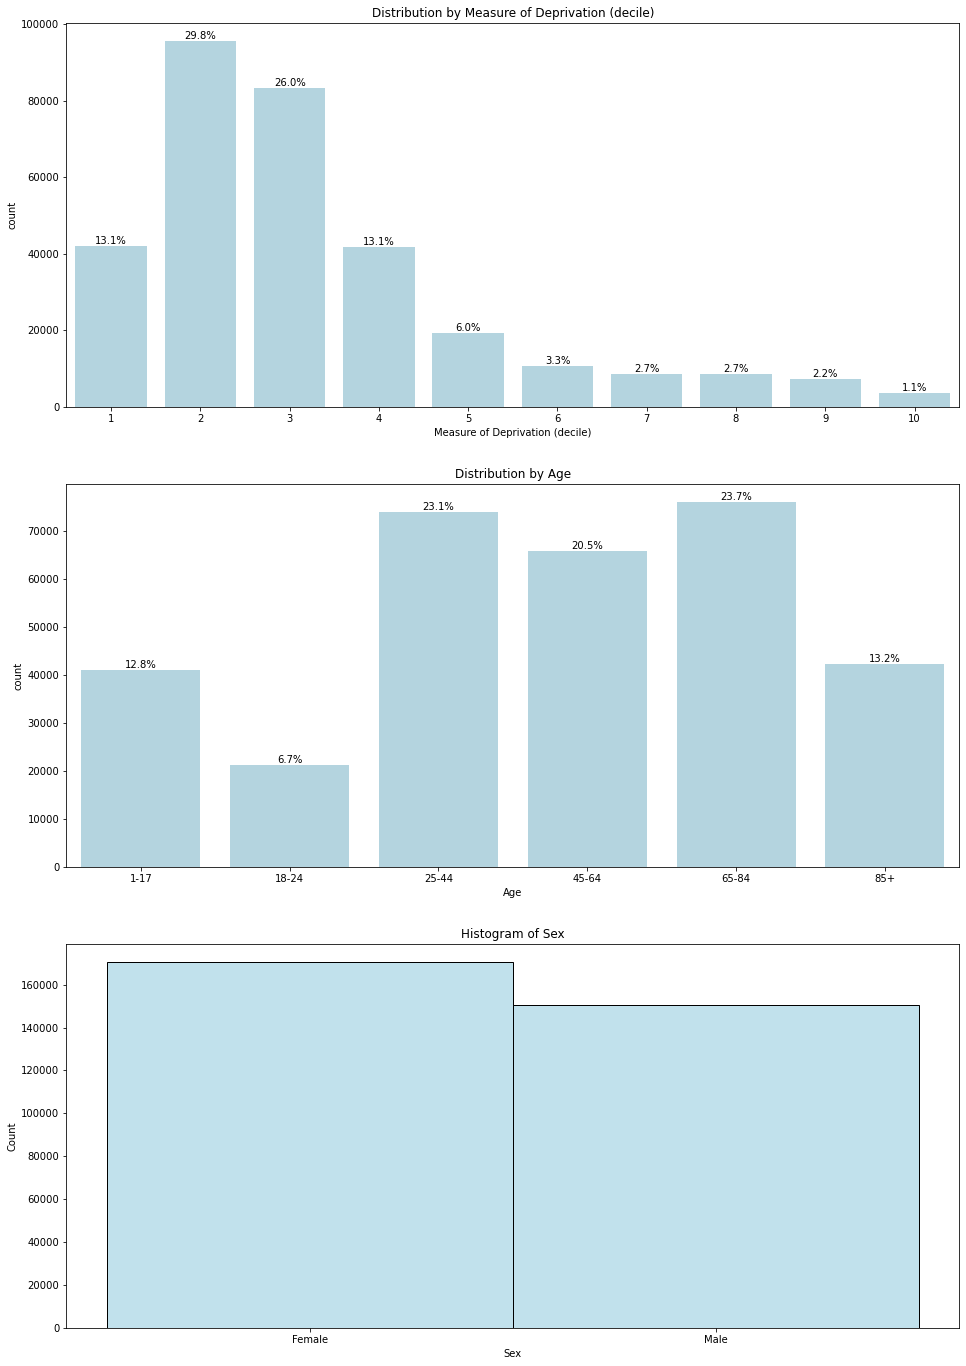

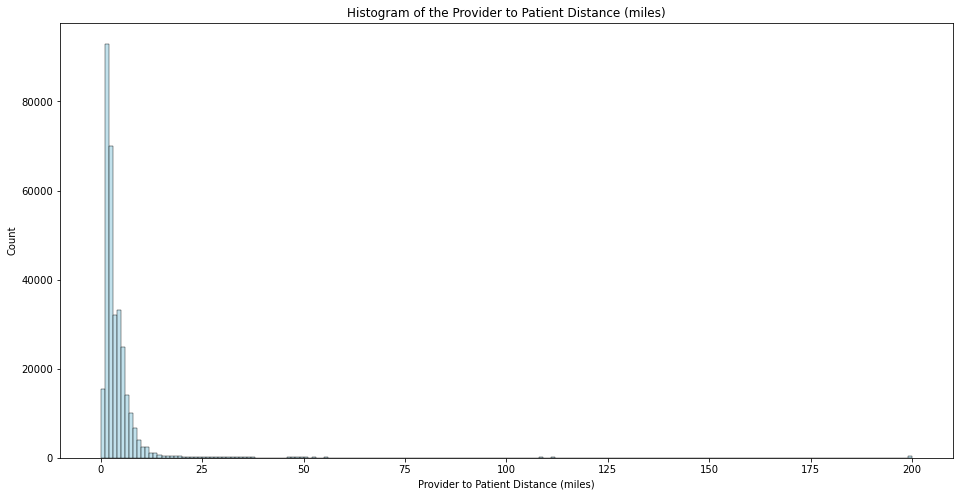

In [277]:
# Creating a graphs
univariate_multiplot(aedata_df,['IMD_Decile_From_LSOA','Age_Band','Sex'])
# Plot the histogram of the log of the value
x_var=rename_variable('Provider_Patient_Distance_Miles')
plt.figure(figsize=(16,8))
sns.histplot(data=aedata_df, x='Provider_Patient_Distance_Miles', color='lightblue', binwidth=1)
plt.xlabel(x_var)
plt.title(f'Histogram of the {x_var}')

* It could be seen that majority of the A&E consults are patients that are coming from poorer areas
* Majority are adults from 25 to 84 years old
* There are more consults from the sex coded as 2, but their number is not that far from the other sex.
* There is a long tail in the distribution for provider to patient distance

C:\Users\gener\AppData\Local\Temp\ipykernel_28012\3774176253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aedata_df['log_distance']=aedata_df['Provider_Patient_Distance_Miles'].apply(lambda x: np.log10(x) if x>0 else np.log10(0.5))


([<matplotlib.axis.XTick at 0x17fc1d472e0>,
 [Text(0.0, 0, '1'),
  Text(0.5, 0, '3.16'),
  Text(1.0, 0, '10'),
  Text(1.5, 0, '31.63'),
  Text(2.0, 0, '100'),
  Text(2.5, 0, '316.23')])

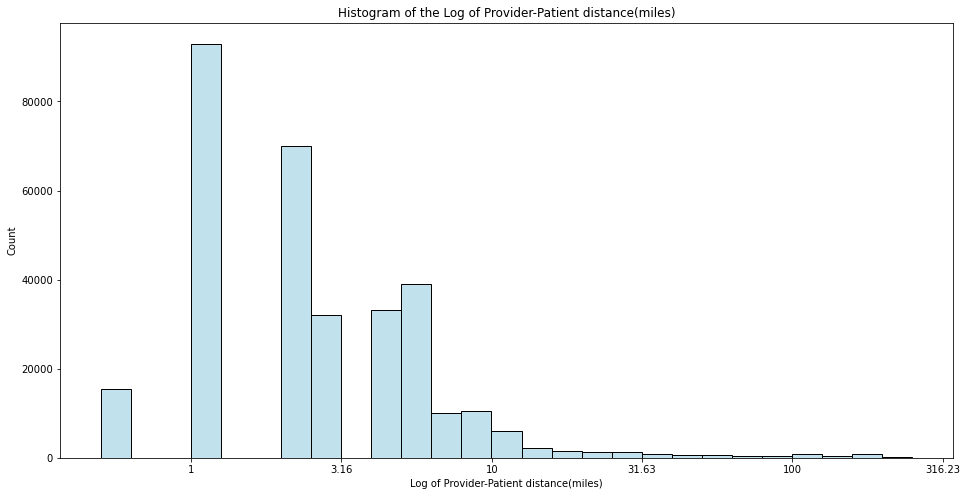

In [278]:
# Compute for the log value of the time in min, use 0.5 in place of 0 min
aedata_df['log_distance']=aedata_df['Provider_Patient_Distance_Miles'].apply(lambda x: np.log10(x) if x>0 else np.log10(0.5))
# Plot the histogram of the log of the value
x_var=rename_variable('log_distance')
plt.figure(figsize=(16,8))
sns.histplot(data=aedata_df, x='log_distance', color='lightblue', binwidth=0.1)
plt.xlabel(x_var)
plt.title(f'Histogram of the {x_var}')
# Change the xticks to be more understandable
plt.xticks([0.0,0.5,1.0,1.5,2.0,2.5], [1, 3.16, 10, 31.63, 100, 316.23])

* It could be seen that the majority of patients are located 1 mile from the A&E care provider

### Temporal factors

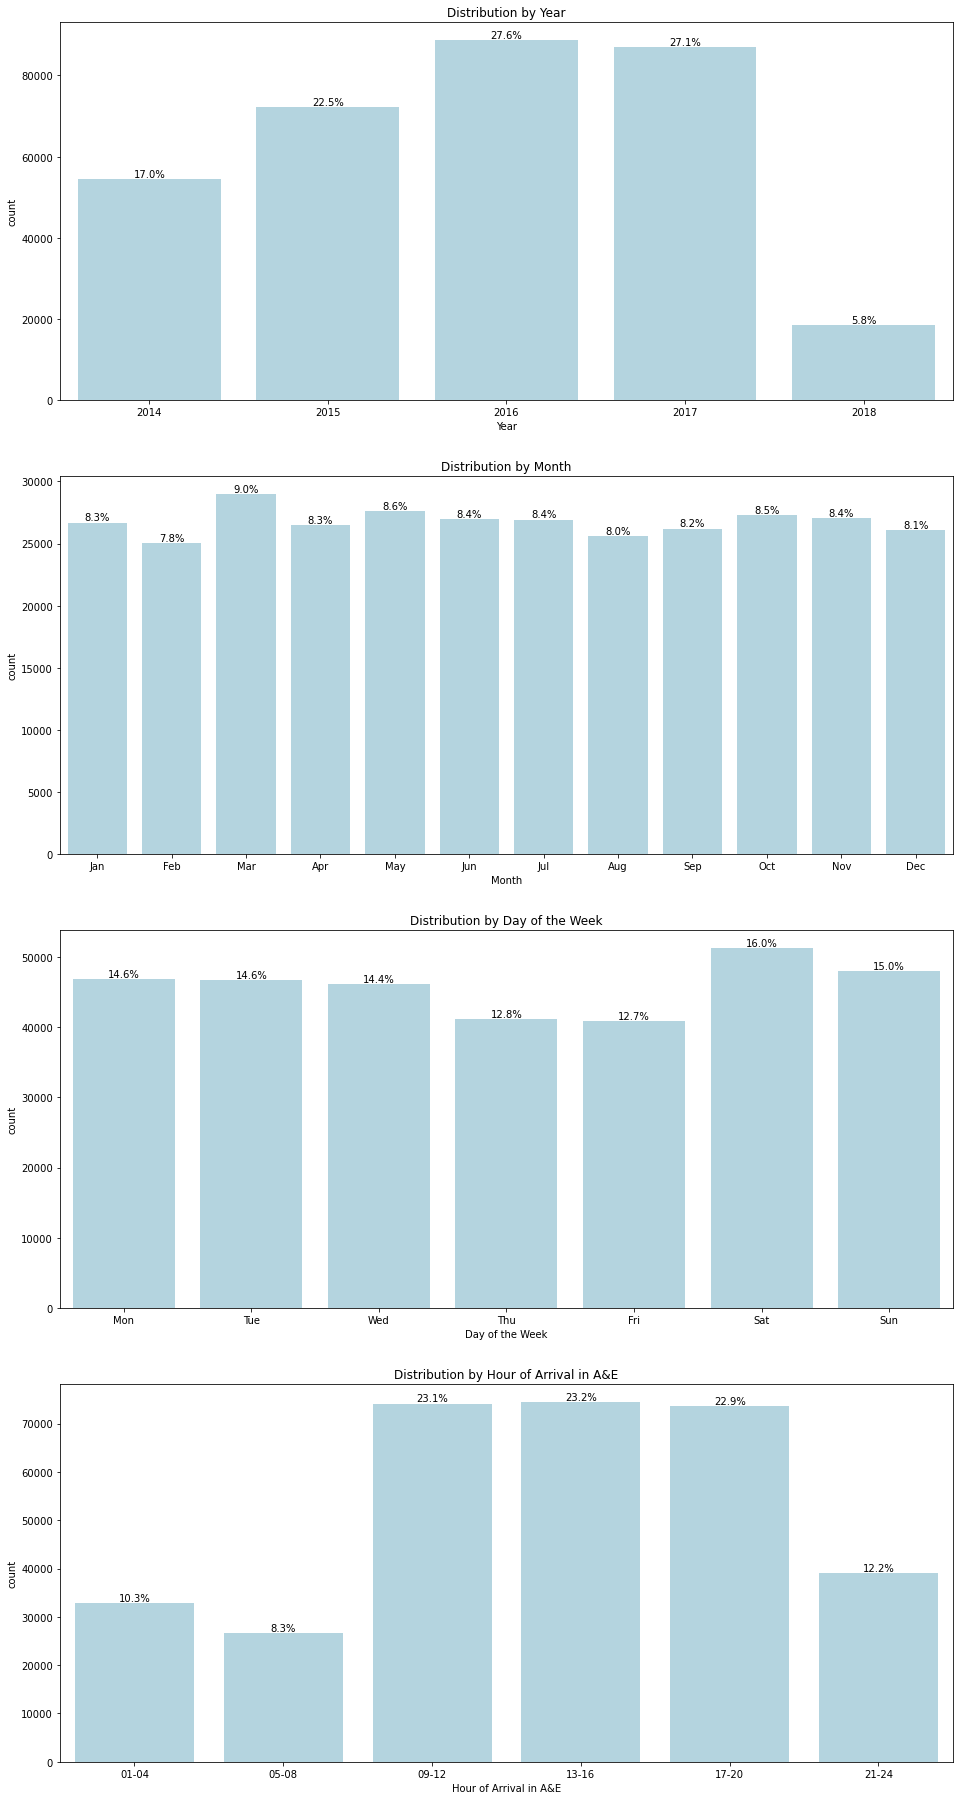

In [279]:
# Creating a graph
univariate_multiplot(aedata_df,['Year','Month','Weekday', 'AE_Arrive_HourOfDay'])

* Number of AE consults stabilized at year 2016 and 2017. It is important to note that our dataset does not contain the data for the entire year of 2014 and 2018
* By month the highest number of consult is during March adn the lowest is at February. It is also important to note that February has also the month with least amount of days
* Total count of admissions is the highest during the Saturdays and the Lowest at Fridays and Thursdays
* Highest number of admissions happens at 0900 to 2000 and lowest at 05-08.

Since the data is from March 2014 to March 2018 the difference in number of days by year and by month might skew the distribution so I proceeded to look at the distribution of the daily admission by time period.

In [280]:
# Dataframe for daily admissions
daily_admission=aedata_df.groupby(['AE_Arrive_Date']).apply(lambda x: pd.Series({
    'num_of_admissions':x['AE_Arrive_Date'].count(),
    'Year':x['Year'].unique()[0],
    'Month':x['Month'].unique()[0],
    'Weekday':x['Weekday'].unique()[0]
})).reset_index()

In [281]:
# Compute for the median daily admission by year
da_by_year=daily_admission.groupby(['Year']).apply(lambda x: pd.Series({
    'median':x['num_of_admissions'].median()
})).reset_index()

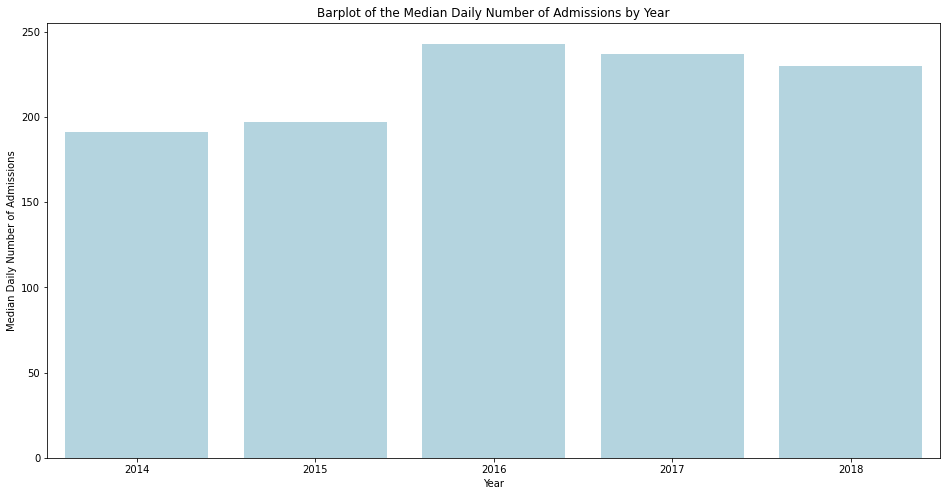

In [282]:
# Create a bar plot for the median daily admission
create_barplot_mda(da_by_year,'Year','median')

* By looking at the daily admissions by year we could see a difference in the distribution by year. Now we could see that there is a spike in admissions from 2015 to 2016, compared in a gradual increase from 2014 to 2016 as we had seen earlier for the total admissions, then a slow decline but still above the 2015 values

In [283]:
# Compute for the median daily admission by month
da_by_month=daily_admission.groupby(['Month']).apply(lambda x: pd.Series({
    'median':x['num_of_admissions'].median()
})).reset_index()

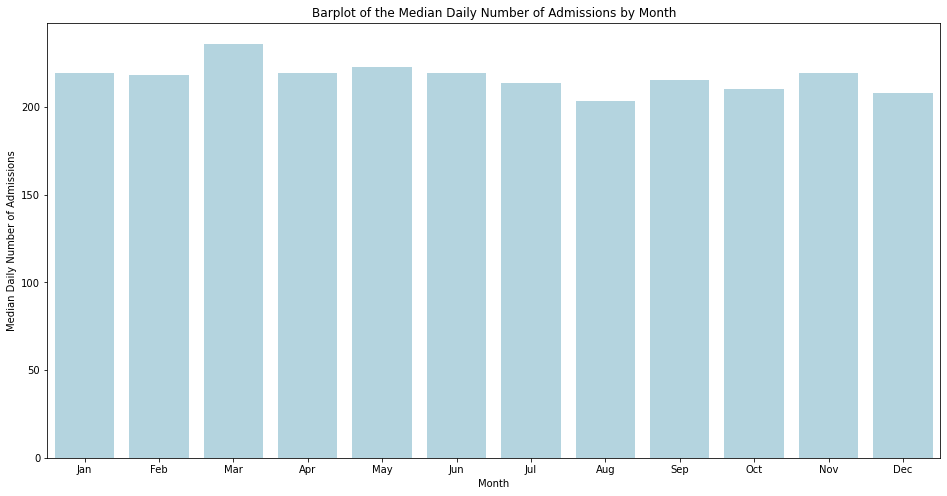

In [284]:
# Create a bar plot for the monthly daily admission
create_barplot_mda(da_by_month,'Month','median')

* Looking at the daily admissions, median number of admissions is highest for March same month that also have the highest number of admissions while August is seen as the lowest in terms of median daily admission.

In [285]:
# Compute for the median daily admission by weekday
da_by_day=daily_admission.groupby(['Weekday']).apply(lambda x: pd.Series({
    'median':x['num_of_admissions'].median()
})).reset_index()

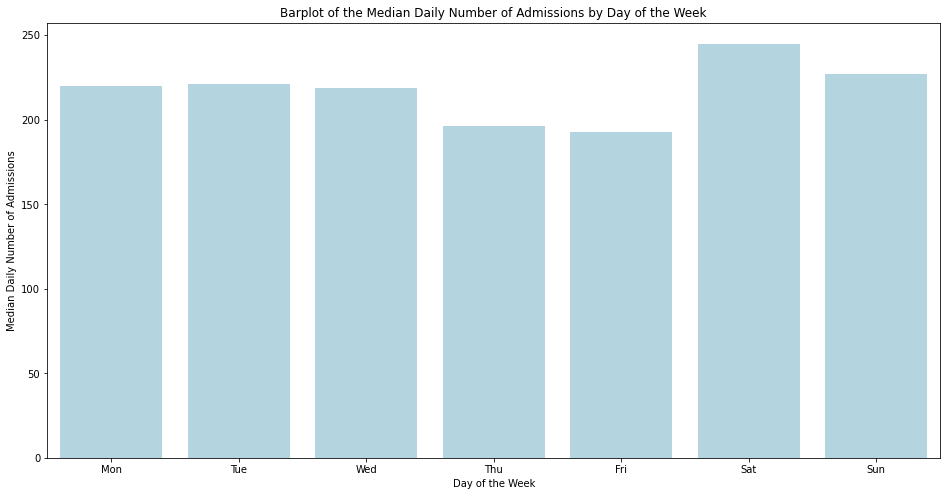

In [286]:
# Create a box plot for the daily admission by day
create_barplot_mda(da_by_day,'Weekday','median')

* The median daily number of admissions is lowest during Thursdays and Fridays and the highest Saturday. This distribution is similar to the total count.

In [287]:
# Dataframe for daily admissions by the hour of day
daily_admission_byhour=aedata_df.groupby(['AE_Arrive_Date','AE_Arrive_HourOfDay']).apply(lambda x: pd.Series({
    'num_of_admissions':x['AE_Arrive_Date'].count()
})).reset_index()

In [288]:
# Compute for the median daily admission by weekday
da_by_hour=daily_admission_byhour.groupby(['AE_Arrive_HourOfDay']).apply(lambda x: pd.Series({
    'median':x['num_of_admissions'].median()
})).reset_index()

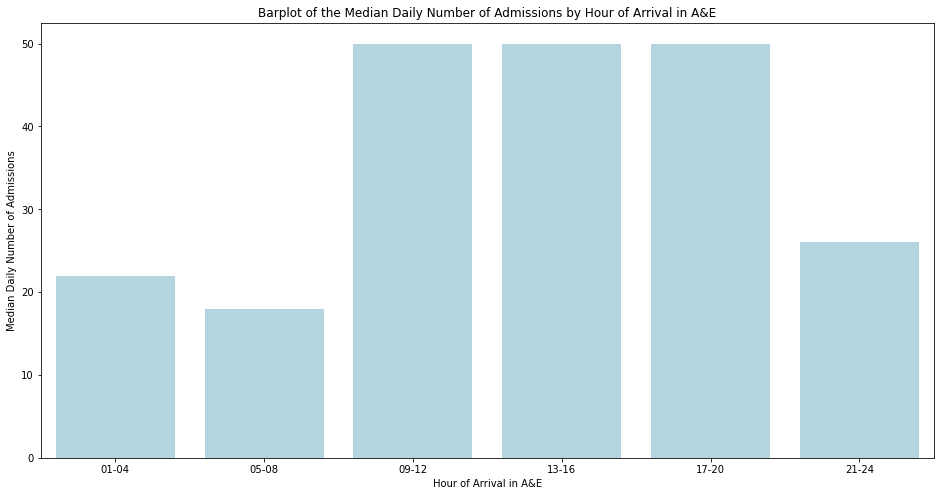

In [289]:
# Create a box plot for the monthly daily admission
create_barplot_mda(da_by_hour,'AE_Arrive_HourOfDay','median')

* For the median daily admission by weekday and by hourofday, we could see that the trend is similar that which was found with that of the total number of admission.

### Transfer Method

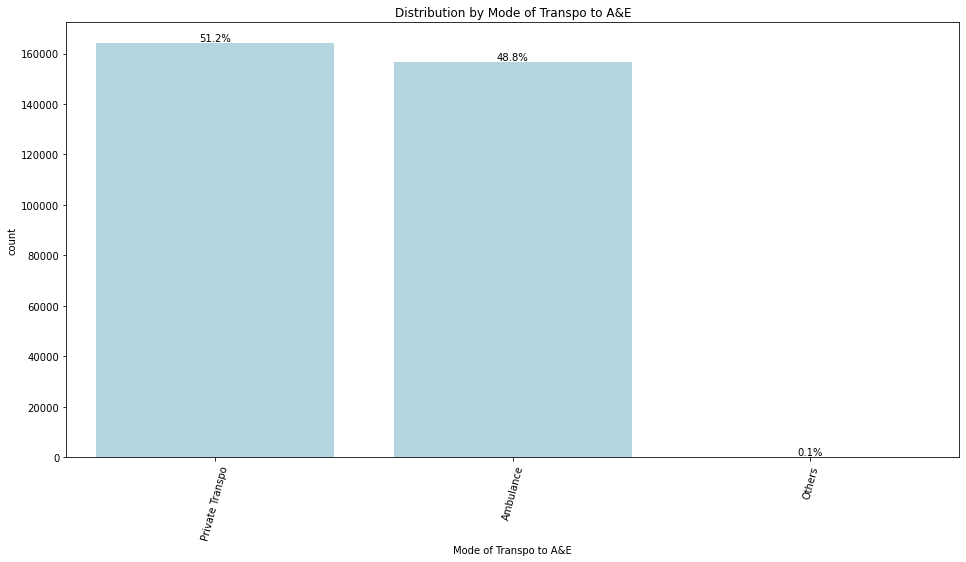

In [313]:
# Creating a graph
create_countplot(aedata_df, 'AE_Arrival_Mode', rename_variable('AE_Arrival_Mode'), counter=0, order=True)

* The other mode of transpo is almost negligeable and there is almost 50-50 split between patients that came in through private transportation and ambulance

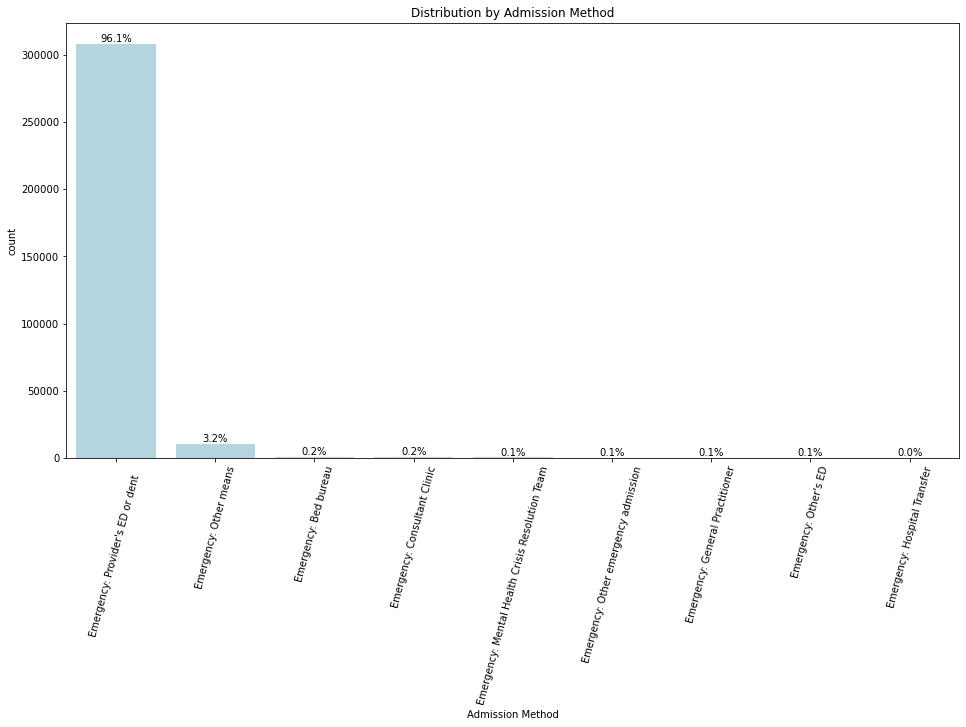

In [312]:
create_countplot(aedata_df, 'Admission_Method', rename_variable('Admission_Method'), counter=0, order=True)

* The vast majority of admissions are admitted through the provider's emergency or dental department. Next at 3.2% is the other means of admission

### Disease and Treatment Factors

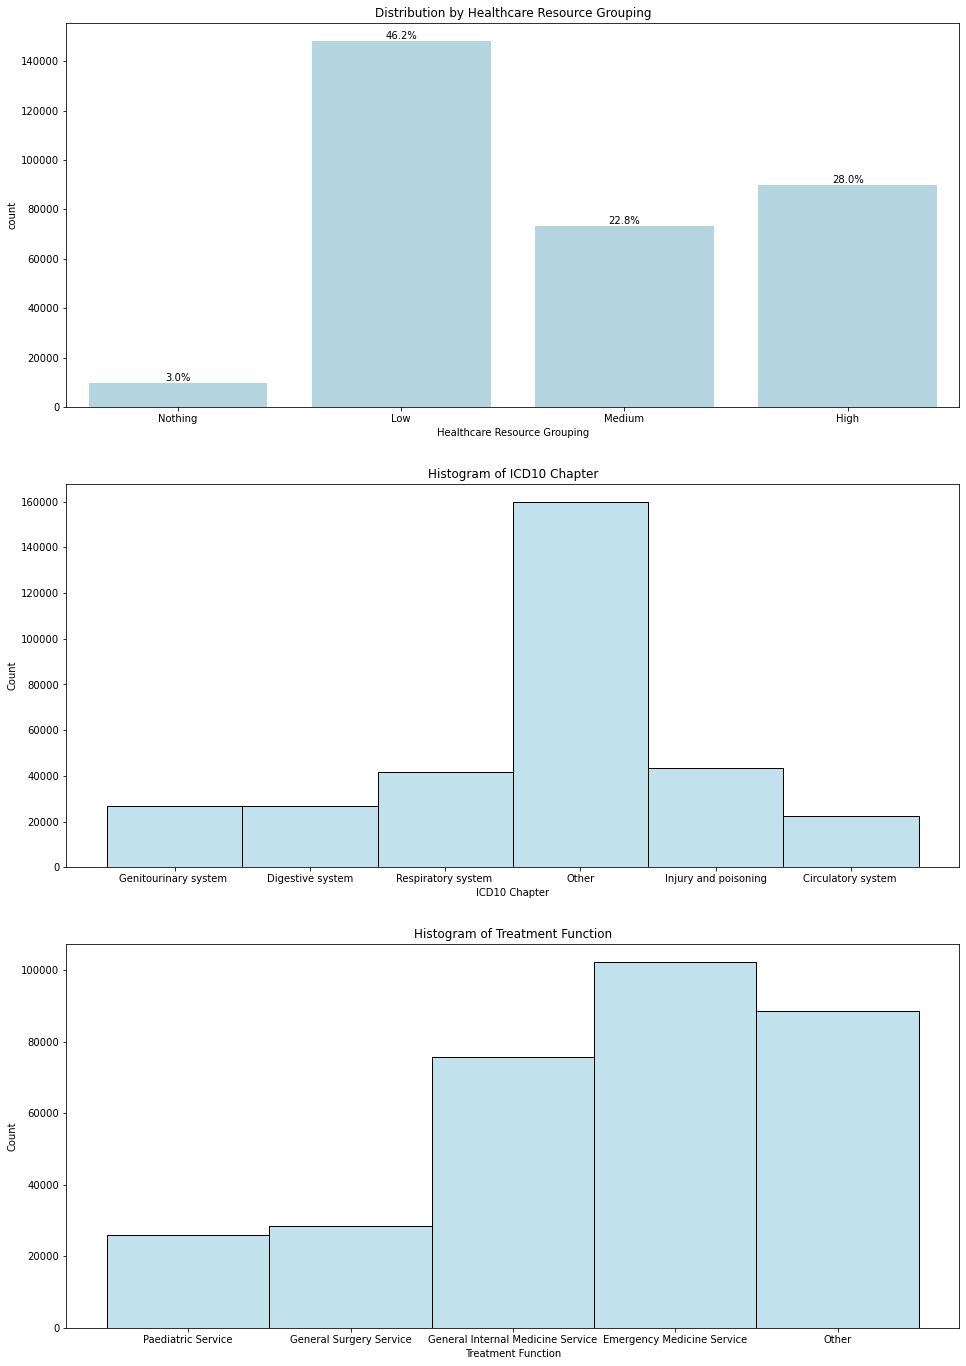

In [291]:
# Creating a graph
univariate_multiplot(aedata_df,['AE_HRG','ICD10_Chapter_Code','Treatment_Function_Code'])

* Almost half of the admissions needed low health care resource but more than a quarter needed high resource
* The highest at more than a quarter of admission is 'Others' meaning that the diagnosis does not fit to a specific ICD10 chapter
* The highest admission for emergency medicine service and more than a quarter are others.

Text(0.5, 1.0, 'Histogram of the Time Spent Admitted(days)')

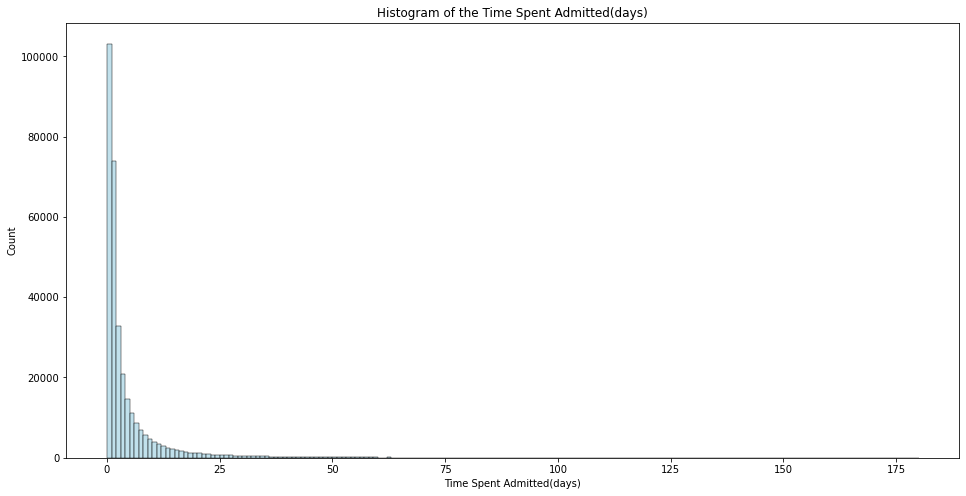

In [292]:
# Compute for the log value of the time in min, use 0.5 in place of 0 min
x_var=rename_variable('Length_Of_Stay_Days')
plt.figure(figsize=(16,8))
sns.histplot(data=aedata_df, x='Length_Of_Stay_Days', color='lightblue', binwidth=1)
plt.xlabel(x_var)
plt.title(f'Histogram of the {x_var}')

C:\Users\gener\AppData\Local\Temp\ipykernel_28012\26776090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aedata_df['log_admission']=aedata_df['Length_Of_Stay_Days'].apply(lambda x: np.log10(x) if x>0 else np.log10(0.5))


([<matplotlib.axis.XTick at 0x17fc44f3e50>,
 [Text(0.0, 0, '1'),
  Text(0.5, 0, '3.16'),
  Text(1.0, 0, '10'),
  Text(1.5, 0, '31.62'),
  Text(2.0, 0, '100'),
  Text(2.5, 0, '316.23')])

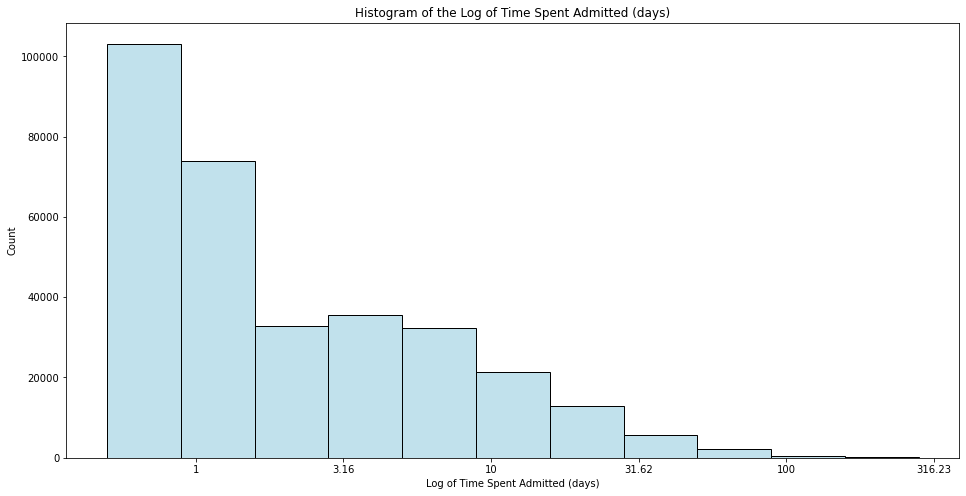

In [293]:
# Compute for the log value of the time in min, use 0.5 in place of 0 min
aedata_df['log_admission']=aedata_df['Length_Of_Stay_Days'].apply(lambda x: np.log10(x) if x>0 else np.log10(0.5))
# Plot the histogram of the log of the value
x_var=rename_variable('log_admission')
plt.figure(figsize=(16,8))
sns.histplot(data=aedata_df, x='log_admission', color='lightblue', binwidth=0.25)
plt.xlabel(x_var)
plt.title(f'Histogram of the {x_var}')
# Change the xticks to be more understandable
plt.xticks([0.0,0.5,1.0,1.5,2.0,2.5], [1, 3.16, 10, 31.62, 100, 316.23])

Total number of days admitted has a long-tailed distribution and when ploted in a logarithmic scale we could see that the highest is at less than a day.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> * The distribution of the amount of time at the A&E is positively skewed with a long tail and because of this I transformed in into logarithmic scale. Since the minimum time is 0 min I opted to remove them from the working dataset. The log scale distribution ilustrates a bimodal distribution.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> * The number of days admitted and the distance between patient and provider both have positively skewed long tailed ditribution so I computed their logarithmic equibalent. Also there are zero values for both variables thus I changed it to 0.5 before doing logarithmic transformation. I decided to do this instead of removing them from the dataset because since both variables are int, the 0 values might mean less than a day of admission and less than a mile in distance which I assumed significant.
> * Other variables that I looked further into are the temporal ones. This is because the dataset is from March 2014 to March 2018 and I feel that just looking at total number of counts would lead to a wrong conclusion when comparing one category to another such as comparing between 2014 and 2018. To resolve this I computed the median daily admission per category per variable.

## Bivariate Exploration
For the bivariate exploration I would look into the relationship of variables in between group and their relationship to my two variables of interest

### A&E Time vs Numeric Variables

First I looked at the interaction of the different numeric variables which includes the following:
* Number of Investigations
* Number of Treatments
* Provider to Patient Distance
* A&E Time
* Length of Stay

But since the distribution of the last three are long tailed, I used the log10 of the values

In [294]:
#variables to be examined
var = ['log_ae_time',\
    'AE_Num_Diagnoses',
    'AE_Num_Investigations',
    'AE_Num_Treatments',
    'log_distance',
    'log_admission'
    ]

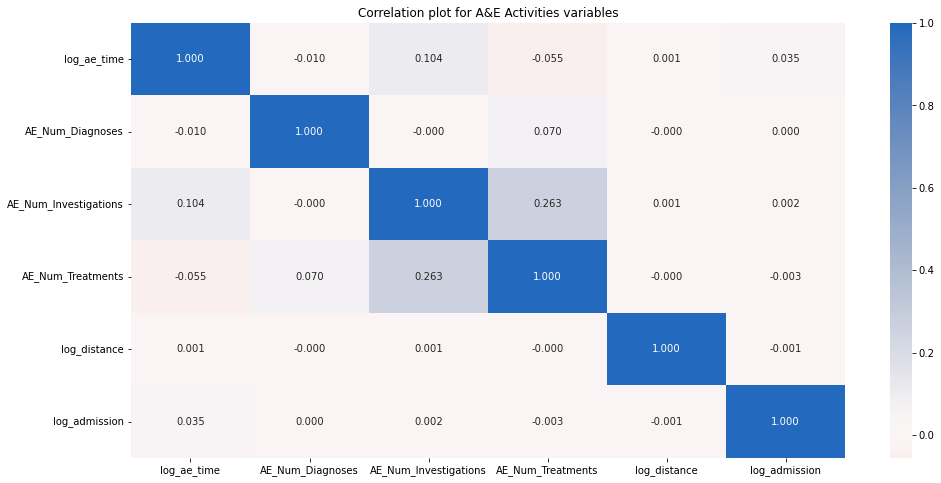

In [295]:
#correlation plot
create_corrplot(aedata_df,var, 'Correlation plot for A&E Activities variables')

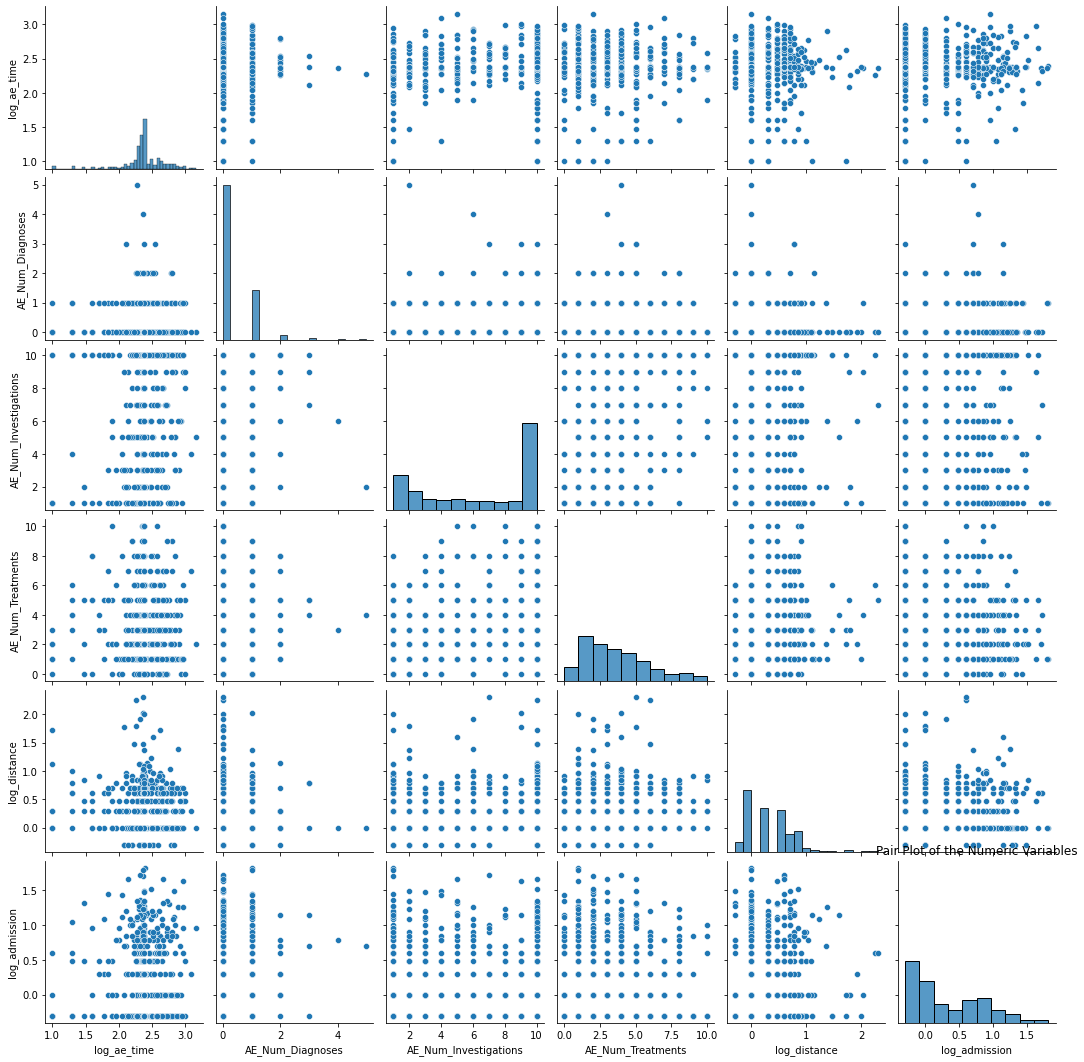

In [296]:
#pair plot
create_pairplot(aedata_df,var,'Pair Plot of the Numeric Variables')

* Time spent in A&E is correlated with the number of investigations done in the A&E
* Number of investigations is also positive correlated with the number of treatments

### A&E Time and Sociodemographic factors
> * `IMD_Decile_From_LSOA`
> * `Age_Band`
> * `Sex`

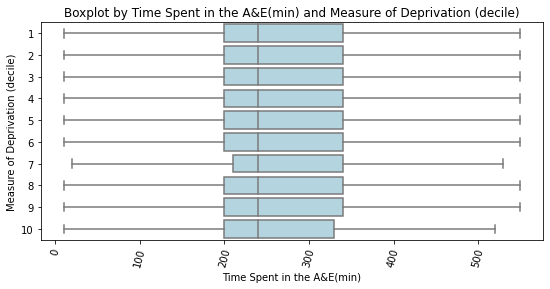

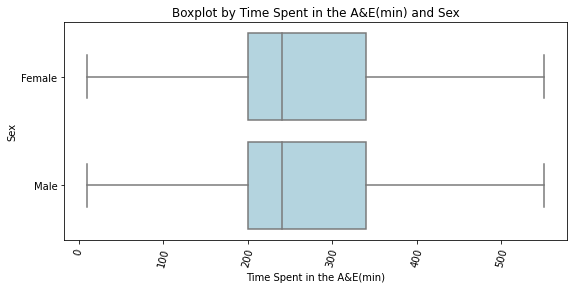

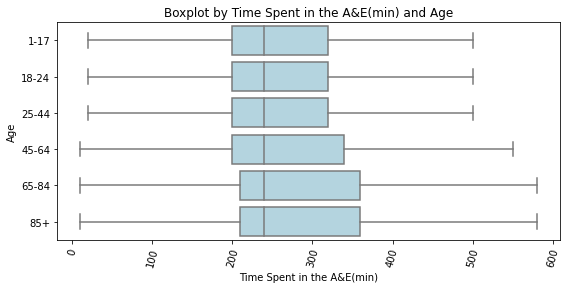

In [297]:
create_bvboxplot(aedata_df,'IMD_Decile_From_LSOA','AE_Time_Mins',False)
create_bvboxplot(aedata_df,'Sex','AE_Time_Mins', False)
create_bvboxplot(aedata_df,'Age_Band','AE_Time_Mins', False)

* The median time spent in the A&E is the same for all variables and the minimum and maximum limit is similar within each cathegory, except for age, wherein the maximum limit can be seen increasing after the age band 25-44.

### Temporal factors
> * `Year`
> * `Month`
> * `Weekday`
> * `AE_Arrive_HourOfDay`

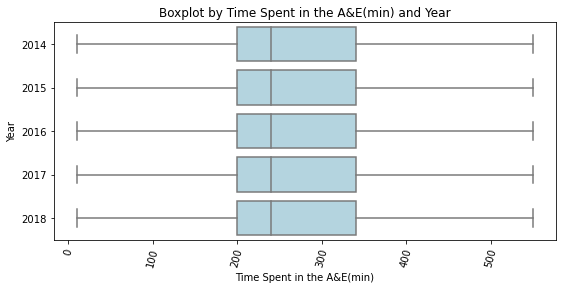

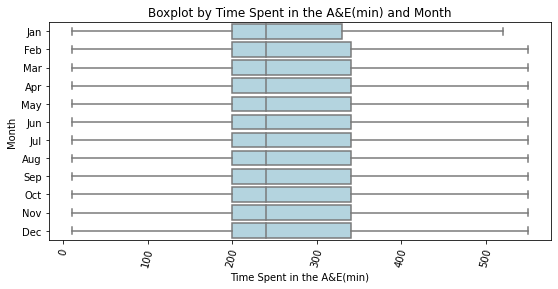

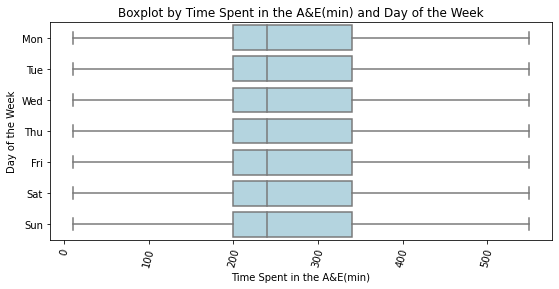

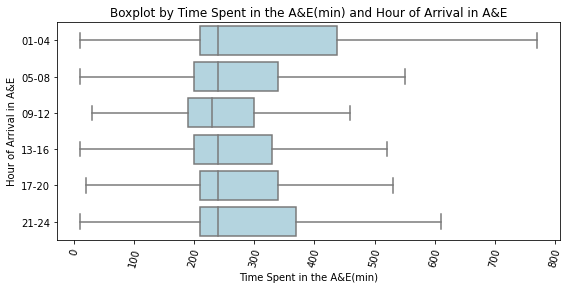

In [298]:
create_bvboxplot(aedata_df,'Year','AE_Time_Mins', False)
create_bvboxplot(aedata_df,'Month','AE_Time_Mins', False)
create_bvboxplot(aedata_df,'Weekday','AE_Time_Mins', False)
create_bvboxplot(aedata_df,'AE_Arrive_HourOfDay','AE_Time_Mins', False)

* Of the four variables distribution of time spent in the A&E is the same by year and by day of the week.
* Looking the data by month, distribution is similar for all months except for January where the upper limit is slightly lower.
* As for the hour of arrival in A&E, there is huge variation in the interquartal range for between each category with time from 01-04 having the largest higher limit and 09-12 the smallest.

### Transfer Method
> * `AE_Arrival_Mode`
> * `Admission_Method`

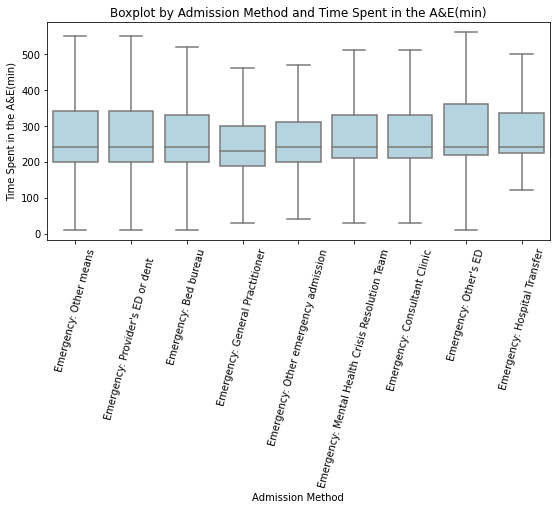

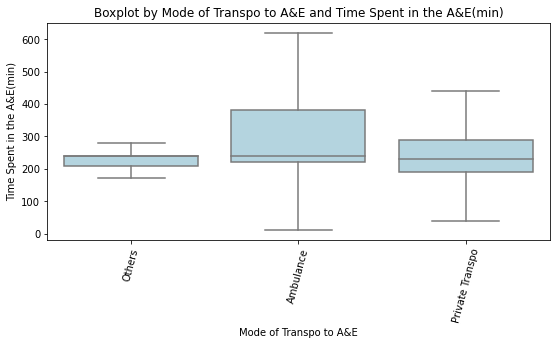

In [299]:
create_bvboxplot(aedata_df,'AE_Time_Mins','Admission_Method',False)
create_bvboxplot(aedata_df,'AE_Time_Mins','AE_Arrival_Mode',False)

* For admission method we could see that the admission admitted through hospital transfer have the highest minimum time spent at the A&E but the lowest maximum can be seen with admission throught GP and other emergency admission
* For the arrival mode, mode transportion coded as 1 has the highest range having the lowest minimum but have higher maximum time. The mode transportation 0 have the narrowest range.

### Disease and Treatment Factors
> * `AE_HRG`
> * `ICD10_Chapter_Code`
> * `Treatment_Function_Code`

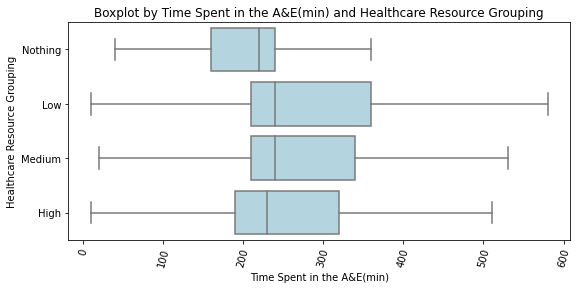

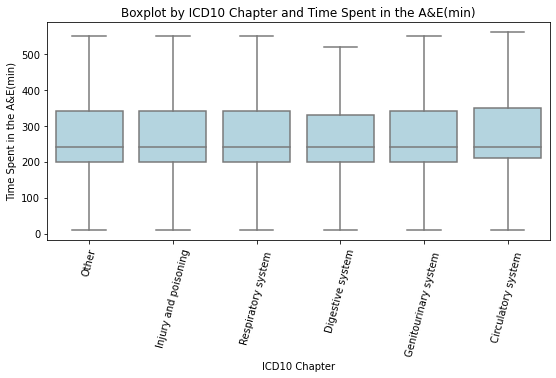

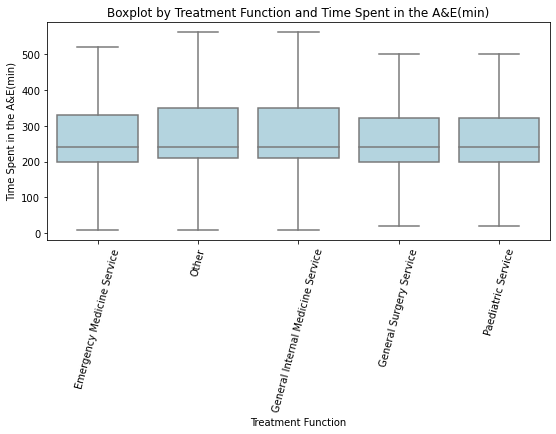

In [300]:
create_bvboxplot(aedata_df,'AE_HRG','AE_Time_Mins',False)
create_bvboxplot(aedata_df,'AE_Time_Mins','ICD10_Chapter_Code')
create_bvboxplot(aedata_df,'AE_Time_Mins','Treatment_Function_Code')

* In terms of healthcare resource gouping, those that do not need health care resource have the lowest median time spent with the A&E while the categories that have the highest median is at low and medium and of the two the low category have the highest upper limit.
* For the ICD10 Chapter most of the type of disease have similar distribution except for digestive system that have slightly lower maximum time spent in the A&E.
* For treatment function, the median time spent in the A&E are the same for all treatment function with general internal medicine service and other service have a slightly higher maximum.

### Other interactions
I focused on the variables that have possible relation to time spent in the AE and look how they interact with other variables.
I would focus on the following variables:
* AE_Num_Investigations
* Age_Band
* AE_Arrive_HourOfDay
* AE_Arrival_Mode
* AE_HRG

* AE_Num_Investigations vs Other variables

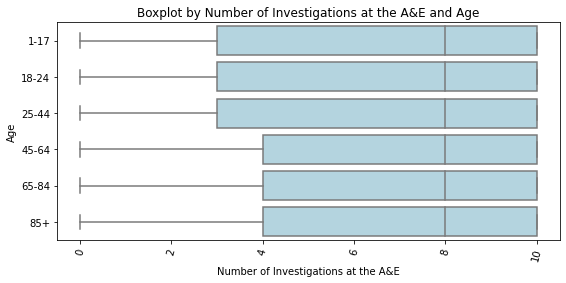

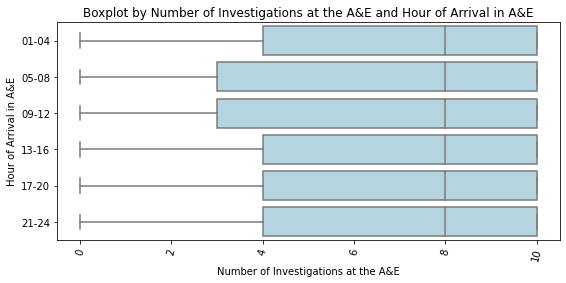

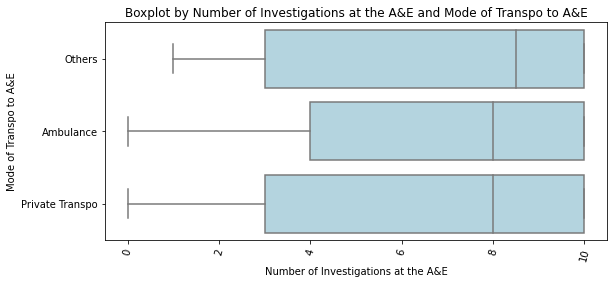

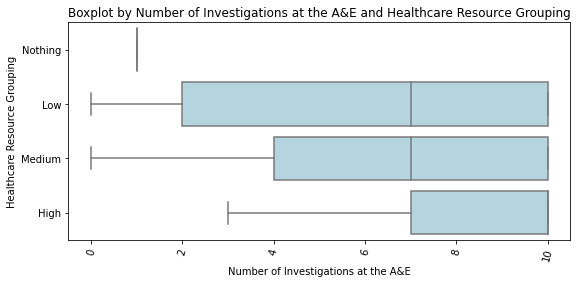

In [314]:
create_bvboxplot(aedata_df,'Age_Band','AE_Num_Investigations',False)
create_bvboxplot(aedata_df,'AE_Arrive_HourOfDay','AE_Num_Investigations',False)
create_bvboxplot(aedata_df,'AE_Arrival_Mode','AE_Num_Investigations',False)
create_bvboxplot(aedata_df,'AE_HRG','AE_Num_Investigations',False)

* Median number of investigations done in the AE is 8 for all age range but the first quartile of patient less thang 45 years old have lower number of investigations.
* The median is the same for hour of arrival with the first quartile of for patient coming at 05-12 lower then the first quartile of the rest.
* Other mode transportation have a median greater than the other two and the first quartile of ambulance is higher that that of patients that use private transpo.
* Higher healthcare resource seems to be associated with higher number of investigations.

Age vs other variables

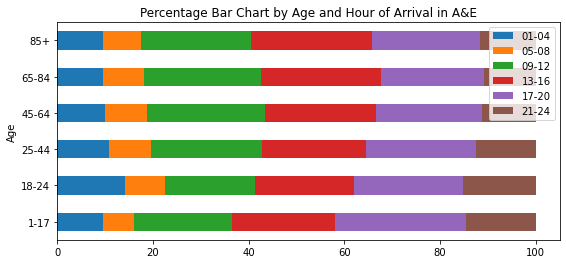

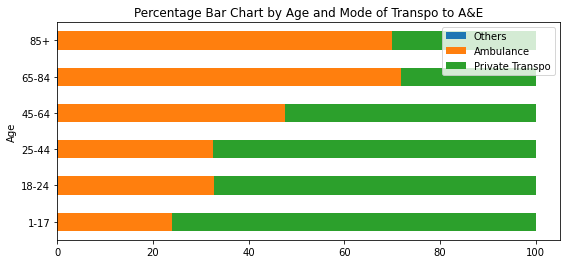

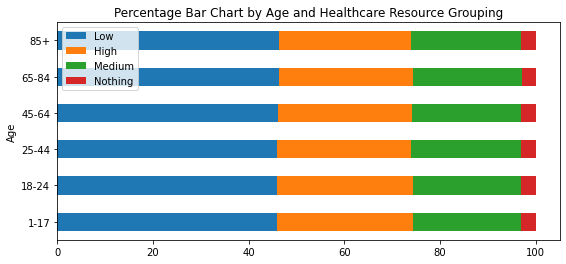

In [333]:
create_bvbarh(aedata_df,'Age_Band','AE_Arrive_HourOfDay')
create_bvbarh(aedata_df,'Age_Band','AE_Arrival_Mode')
create_bvbarh(aedata_df,'Age_Band','AE_HRG')

* For all age group, most of them arrives in the A&E at 0900-2000. The highest percentage of individuals that go to the A&E at 2100-0400 could be seen in the age range 18-24
* Increasing age seems to be associated with more use of ambulance services as a mode of transpo to the A&
* Proportion of healthcare resource grouping is the same for all ages.

Hour of arrival in A&E vs other variables

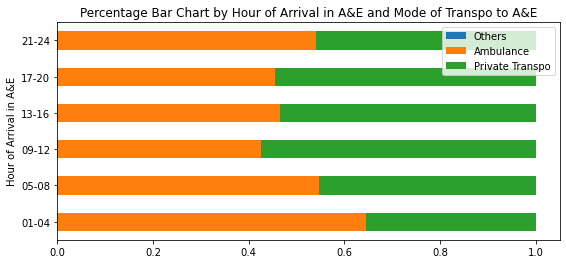

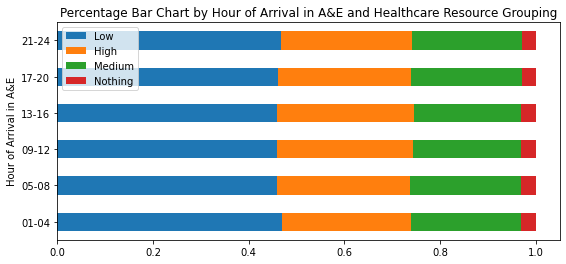

In [326]:
create_bvbarh(aedata_df,'AE_Arrive_HourOfDay','AE_Arrival_Mode')
create_bvbarh(aedata_df,'AE_Arrive_HourOfDay','AE_HRG')

* More than half of patients admitted are transported via ambulance during 2100 to 0800
* Proportion of healthcare resource grouping is the same irrespective of hour of arrival in the A&E

Arrival mode vs other variables

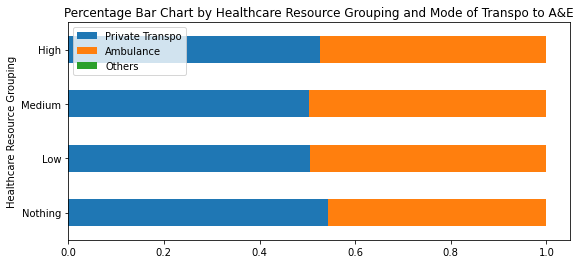

In [327]:
create_bvbarh(aedata_df,'AE_HRG','AE_Arrival_Mode')

* There are sightly more percentage of patients, that needed high healthcare resource and that needed no healthcare resource, utilize private transportation.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> * Time spend in the A&E is positively correlated with the number of investigations done
> * There is more variation interms of time spent in the A&E for patients aged 45 and over
> * There is higher variability in terms of time spent in the A&E of people that arrive during the night (2100-0400) and patients arriving at 0900-1200 stayed the least
> * Arriving via ambulance is associated to more variation in terms of time spent in the A&E
> * For admissions that needed healthcare resource, the higher the need the shorter the stay

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> * Number of investigations in the A&E is positively associated with the number of treatment done and the needed healthcare resource
> * Increasing age and night times see more ambulance use

## Multivariate Exploration


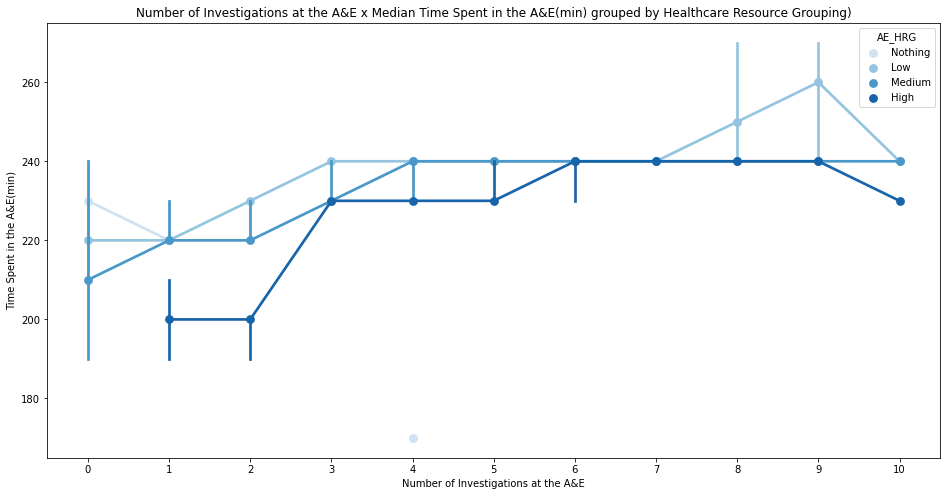

In [306]:
create_mvpointplot(aedata_df,'AE_Num_Investigations','AE_Time_Mins','AE_HRG')

* Up to 6 investigations, an increase in number of investigations also increases the time spent in A&E. Patient that require high healthcare resources spent the least amount in the A&E while the low resource group have the highest and at 8-9 investigation, its median time exceeded 240min which is the median time of the dataset.

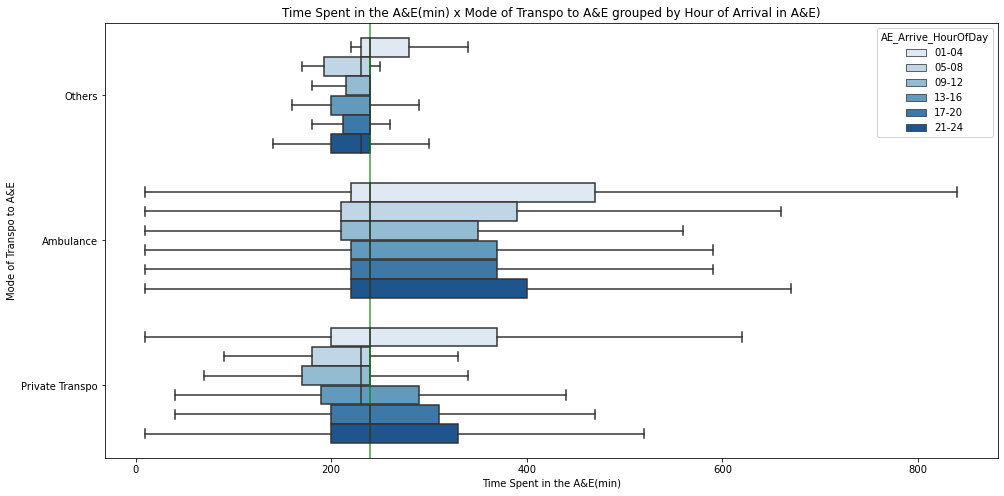

In [307]:
create_mvboxplot(aedata_df,'AE_Time_Mins','AE_Arrival_Mode','AE_Arrive_HourOfDay',False)

*The minimum A&E time for all hours of the day is lowest for patients that came in via ambulances but they also have the highest upper limit. For all transpo method, the hour of the day that see the highest proportion of patients staying more than 240min is at 0100-0400 followed by 2100-2400. Patient brought in via ambulance stayed the least in the AE if they come in at 0900-12000, while the median time is lower than 240min during 0500-1600 for those that use private transportation.

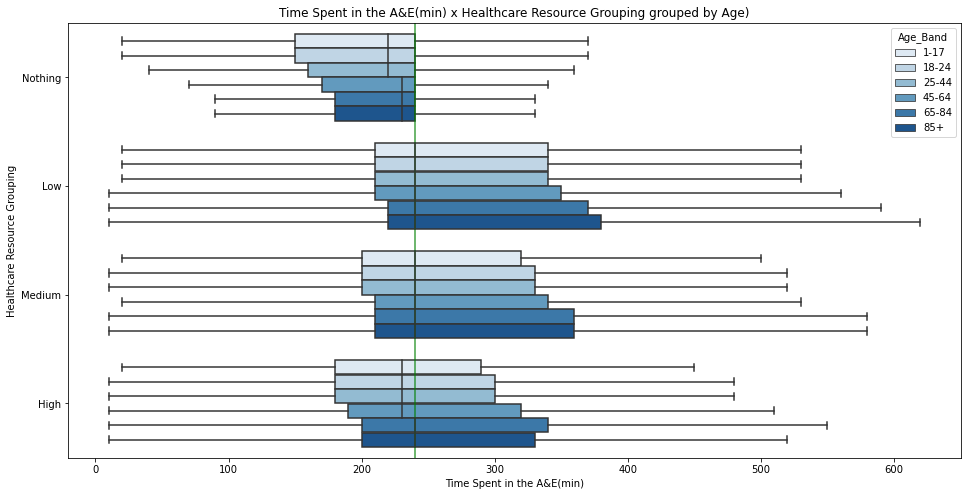

In [308]:
create_mvboxplot(aedata_df,'AE_Time_Mins','AE_HRG','Age_Band',False)

* 75% of patients of all age group that don't need healthcare resource are admitted by the 240min. The next group that have the lowest time in A&E are those that needs high healthcare resource with the median time being less than the population median for patients aged 1-64. For this group, those that are aged 65-84 have the longest time. The low health resource group have the highest limit in terms of time spent in the A&E with age bands from 1-44 having the lowest and the limit increasing as the age increase.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> * Increasing number of investigations, increasing age, and decreasing healthcare resource need is associated with longer time in the A&E
> * Night admissions, those admitted at 2100-0400, could take more time in the A&E but those that come using private vehicles are admitted faster during 0500-1600

### Were there any interesting or surprising interactions between features?

> * One thing that surprised me was that people coming in via private transpo were admitted faster than those that came in through ambulances

## Conclusions
> * Low healthcare resource group, higher number of investigations, older patients, using the ambulance and arriving at night is associated with longer time spent in the A&E
> * Looking back at this exploratory analysis, I have a hard time thinking of what should be included in the analysis. There are around 15 variables in the dataset and if I include all the possible combinations for the bivariate and multivariate analysis, it would be too long and most would not be relevant to the variable of interest. With this I tried to only focus on the variables that might have a relationship to the amount of time in the A&E.
